# Introdução a machine learning  classificação V
___

#### Importando bibliotecas

In [1]:
import pandas as pd
from pandas.plotting._misc import scatter_matrix
import numpy as np

#### Importando dados

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

data = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
data.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


#### Situação horrível de 'azar' onde as classes estão ordenadas por padrão

In [3]:
data_azar = data.sort_values('vendido', ascending=True)
x_azar = data_azar[['preco', 'idade_do_modelo', 'km_por_ano']]
y_azar = data_azar['vendido']
data_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


#### DummyClassifier

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
scores = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = scores['test_score'].mean()
desvio_padrao = scores['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


#### Gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

In [5]:
np.random.seed(SEED)
data['modelo'] = data.idade_do_modelo + np.random.randint(-2, 3, size=10000)
data.modelo = data.modelo + abs(data.modelo.min()) + 1
data.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

#### GroupKFold para analisar como o modelo se comporta com novos grupos

In [7]:
from sklearn.model_selection import GroupKFold
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
scores = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = data.modelo, return_train_score=False)
imprime_resultados(scores)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


#### GroupKFold em um pipeline com StandardScaler e SVC

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
scores = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = data.modelo, return_train_score=False)
imprime_resultados(scores)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


#### DecisionTreeClassifier

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=3)
scores = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = scores['test_score'].mean()
desvio_padrao = scores['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [75.87, 81.53]


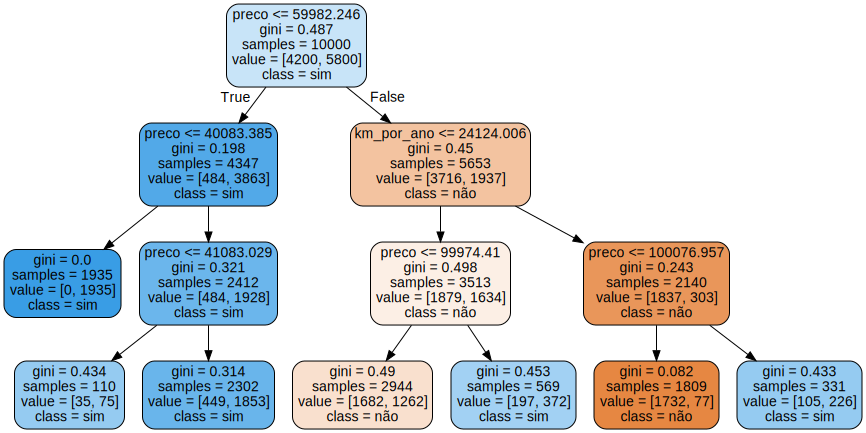

In [10]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, 
                           out_file=None, 
                           filled=True, 
                           rounded=True, 
                           class_names=['não', 'sim'], 
                           feature_names=features
                           )
graph = graphviz.Source(dot_data)
graph


In [11]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=10)
scores = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = scores['test_score'].mean()
desvio_padrao = scores['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.81, 80.25]


#### Explorando hiper parâmetros em uma dimensão

In [12]:
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = data.modelo, return_train_score=True)
    train_score = (results["train_score"].mean() * 100).round(2)
    test_score = (results["test_score"].mean() * 100).round(2)
    print(f'max_depth = {max_depth}, média de treino: {train_score},  média de teste: {test_score}')
    tabela = [max_depth, train_score, test_score]
    return tabela

resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]
resultados = pd.DataFrame(resultados, columns=['max_depth', 'train', 'test'])
resultados.head()

max_depth = 1, média de treino: 75.79,  média de teste: 75.78
max_depth = 2, média de treino: 75.79,  média de teste: 75.78
max_depth = 3, média de treino: 78.75,  média de teste: 78.67
max_depth = 4, média de treino: 78.79,  média de teste: 78.63
max_depth = 5, média de treino: 78.94,  média de teste: 78.56
max_depth = 6, média de treino: 79.17,  média de teste: 78.12
max_depth = 7, média de treino: 79.5,  média de teste: 77.96
max_depth = 8, média de treino: 79.89,  média de teste: 77.86
max_depth = 9, média de treino: 80.46,  média de teste: 77.38
max_depth = 10, média de treino: 81.16,  média de teste: 77.19
max_depth = 11, média de treino: 82.03,  média de teste: 76.97
max_depth = 12, média de treino: 82.89,  média de teste: 76.49
max_depth = 13, média de treino: 83.95,  média de teste: 75.81
max_depth = 14, média de treino: 85.03,  média de teste: 75.66
max_depth = 15, média de treino: 86.14,  média de teste: 75.16
max_depth = 16, média de treino: 87.19,  média de teste: 75.11
ma

,max_depth,train,test
0,1,75.79,75.78
1,2,75.79,75.78
2,3,78.75,78.67
3,4,78.79,78.63
4,5,78.94,78.56


#### OVERFIT: ficou 'perfeito' para o treino mas ruim para o teste

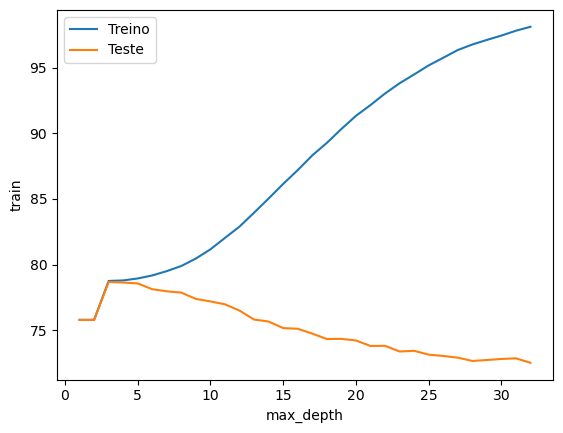

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x='max_depth', y='train', data=resultados)
sns.lineplot(x='max_depth', y='test', data=resultados)
plt.legend(['Treino', 'Teste'])

#### Mostrando melhores médias

In [14]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.75,78.67
3,4,78.79,78.63
4,5,78.94,78.56
5,6,79.17,78.12
6,7,79.50,77.96


#### Explorando hiper parâmetros em duas dimensão

In [15]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = data.modelo, return_train_score=True)
    train_score = (results["train_score"].mean() * 100).round(2)
    test_score = (results["test_score"].mean() * 100).round(2)
    print(f'max_depth = {max_depth}, min_sample_leaf = {min_samples_leaf}, média de treino: {train_score},  média de teste: {test_score}')
    tabela = [max_depth,min_samples_leaf,  train_score, test_score]
    return tabela

def buscas():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = buscas()
resultados.head()

max_depth = 1, min_sample_leaf = 32, média de treino: 75.79,  média de teste: 75.78
max_depth = 1, min_sample_leaf = 64, média de treino: 75.79,  média de teste: 75.78
max_depth = 1, min_sample_leaf = 128, média de treino: 75.79,  média de teste: 75.78
max_depth = 1, min_sample_leaf = 256, média de treino: 75.79,  média de teste: 75.78
max_depth = 2, min_sample_leaf = 32, média de treino: 75.79,  média de teste: 75.78
max_depth = 2, min_sample_leaf = 64, média de treino: 75.79,  média de teste: 75.78
max_depth = 2, min_sample_leaf = 128, média de treino: 75.79,  média de teste: 75.78
max_depth = 2, min_sample_leaf = 256, média de treino: 75.79,  média de teste: 75.78
max_depth = 3, min_sample_leaf = 32, média de treino: 78.75,  média de teste: 78.67
max_depth = 3, min_sample_leaf = 64, média de treino: 78.75,  média de teste: 78.67
max_depth = 3, min_sample_leaf = 128, média de treino: 78.75,  média de teste: 78.67
max_depth = 3, min_sample_leaf = 256, média de treino: 78.75,  média de

,max_depth,min_samples_leaf,train,test
0,1,32,75.79,75.78
1,1,64,75.79,75.78
2,1,128,75.79,75.78
3,1,256,75.79,75.78
4,2,32,75.79,75.78


#### Mostrando melhores médias

In [16]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.75,78.67
12,4,32,78.75,78.67
14,4,128,78.75,78.67
13,4,64,78.75,78.67
8,3,32,78.75,78.67


#### Procurando correlação

In [17]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536594,-0.027530
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409467,0.350465
train,5.365935e-01,-4.094665e-01,1.000000,0.115960
test,-2.753030e-02,3.504655e-01,0.115960,1.000000


<AxesSubplot:>

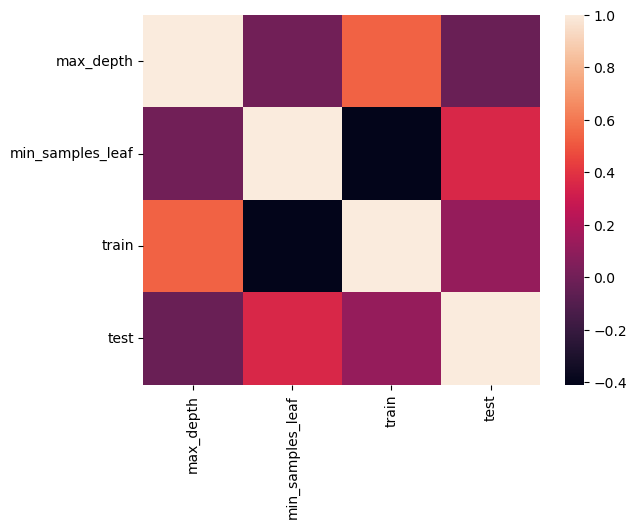

In [18]:
sns.heatmap(corr, )

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

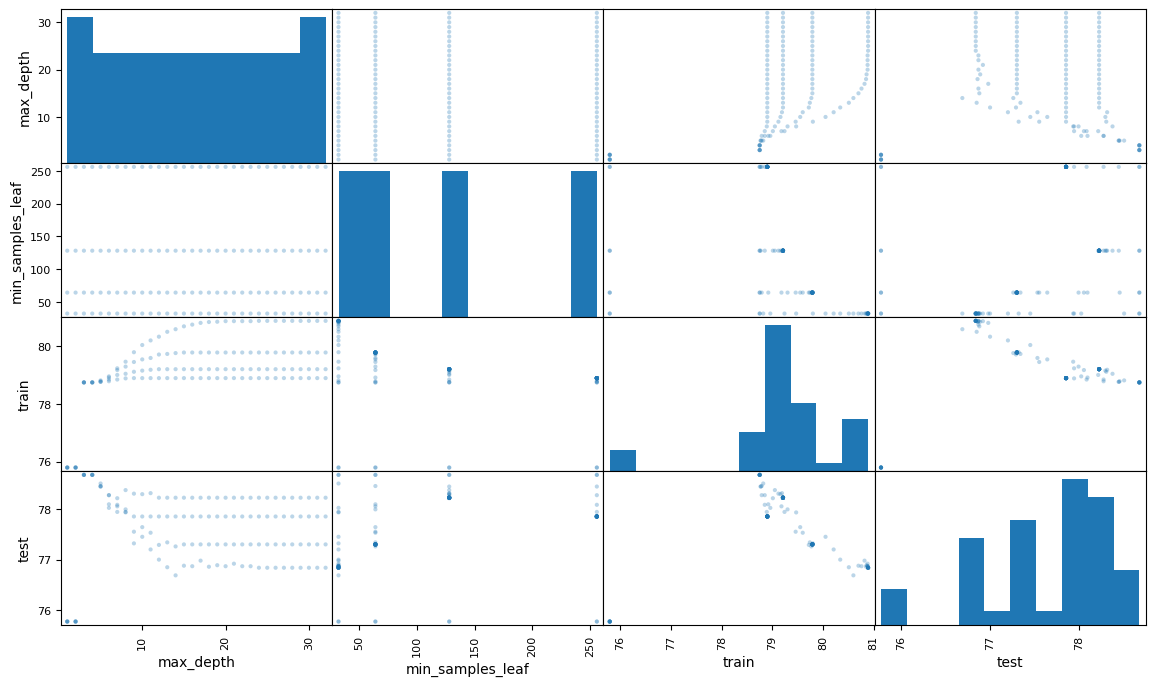

In [19]:
scatter_matrix(resultados, figsize=(14, 8), alpha=0.3)

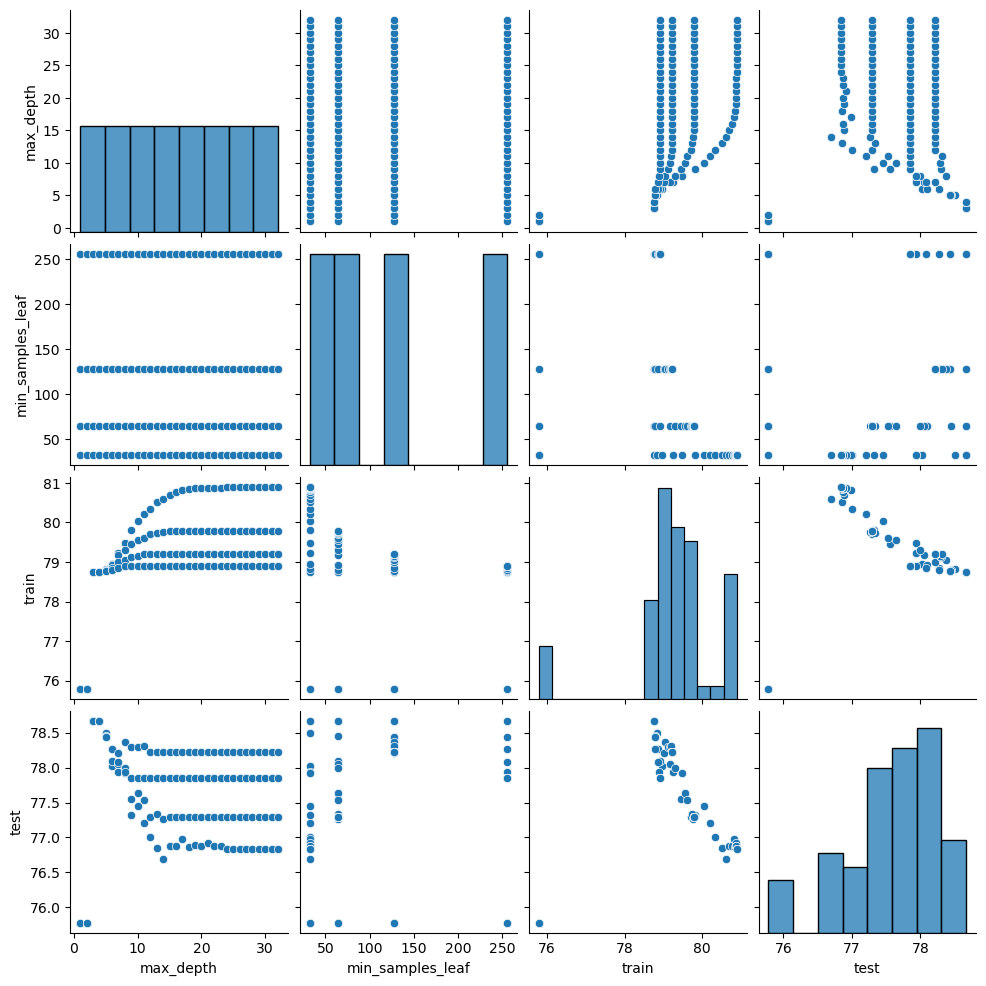

In [20]:
sns.pairplot(resultados)

<AxesSubplot:>

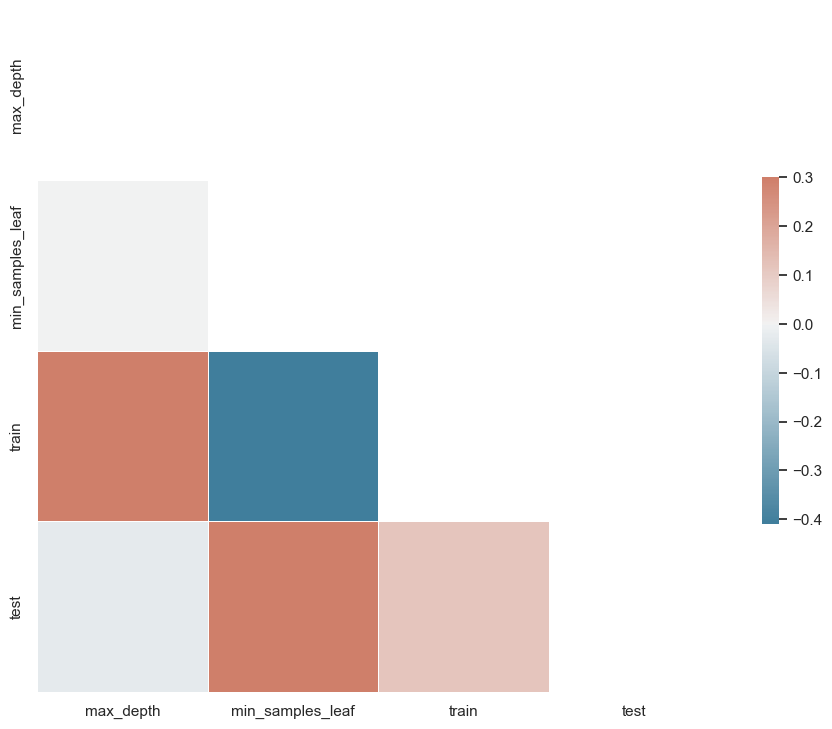

In [21]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Explorando hiper parâmetros em três dimensões

In [27]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = data.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = (results["train_score"].mean() * 100).round(2)
    test_score = (results["test_score"].mean() * 100).round(2)
    # print(f'max_depth = {max_depth}, min_sample_leaf = {min_samples_leaf}, min_samples_split = {min_samples_split} média de treino: {train_score},  média de teste: {test_score}')
    tabela = [max_depth, min_samples_leaf, min_samples_split,   train_score, test_score, fit_time, score_time]
    return tabela

def buscas():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

resultados = buscas()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.79,75.78,0.003420,0.001442
1,1,32,64,75.79,75.78,0.004474,0.001580
2,1,32,128,75.79,75.78,0.004710,0.000858
3,1,32,256,75.79,75.78,0.004691,0.001523
4,1,64,32,75.79,75.78,0.002627,0.001622


#### Mostrando melhores médias

In [28]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
62,4,256,128,78.75,78.67,0.026516,0.006347
48,4,32,32,78.75,78.67,0.031317,0.005709
34,3,32,128,78.75,78.67,0.007442,0.002264
35,3,32,256,78.75,78.67,0.008634,0.000686
36,3,64,32,78.75,78.67,0.009034,0.000590


#### Procurando correlação

In [29]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529494,0.011836,-0.059069,-0.240138
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341131,0.287632,-0.315455,0.037797
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.125913,0.133498,-0.048112,-0.042557
train,5.294944e-01,-3.411305e-01,-1.259134e-01,1.000000,0.247471,0.382328,-0.038855
test,1.183623e-02,2.876316e-01,1.334982e-01,0.247471,1.000000,0.318831,0.176438
fit_time,-5.906902e-02,-3.154549e-01,-4.811186e-02,0.382328,0.318831,1.000000,0.460671
score_time,-2.401385e-01,3.779680e-02,-4.255663e-02,-0.038855,0.176438,0.460671,1.000000


<AxesSubplot:>

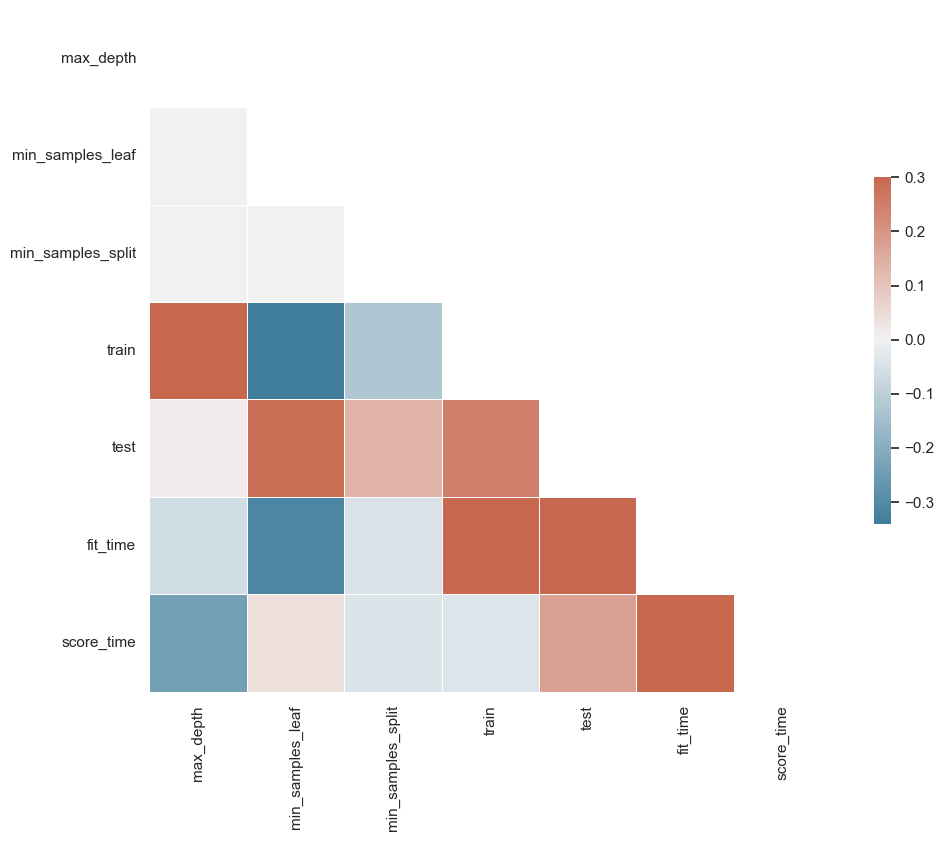

In [30]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Explorando espaço de hiper parâmetros com GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv=GroupKFold(n_splits=10)
                     )

busca.fit(x_azar, y_azar, groups=data.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010768,0.003152,0.001078,0.002356,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.007197,0.003726,0.001782,0.003376,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.007920,0.001958,0.000809,0.001285,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007949,0.002530,0.000526,0.001348,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.008145,0.002549,0.000598,0.001509,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


#### Melhores parâmetros

In [33]:
busca.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

#### Melhor score

In [37]:
(busca.best_score_ * 100).round(2)

78.67

#### Melhor modelo

In [38]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

#### Utilizando o melhor modelo no mundo real

In [43]:
from sklearn.metrics import accuracy_score

# evitar esta abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar)
print(f'A acurácia foi de {(accuracy * 100).round(2)}%')

A acurácia foi de 78.75%


#### Como ter uma estimativa sem esse vício nos dados que eu já vi?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=GroupKFold(n_splits=10), groups=data.modelo)

c:\Users\Ewerton\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ewerton\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ewerton\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\Ewerton\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(sel

#### Infelizmente como o pandas não suporta nested validation com group k foldenão conseguimos prever o resultado para novos grupos

In [45]:
from sklearn.model_selection import GridSearchCV, KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv=KFold(n_splits=5, shuffle=True)
                     )

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006965,0.002795,0.003867,0.002975,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006550,0.001919,0.000309,0.000617,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.007191,0.001937,0.001429,0.001222,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.005374,0.001606,0.000803,0.001605,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008019,0.000031,0.000000,0.000000,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores

array([0.782 , 0.7885, 0.7795, 0.8085, 0.7755])

In [49]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [50]:
imprime_scores(scores)

Accuracy médio 78.68
Intervalo [76.35, 81.01]


In [51]:
busca.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

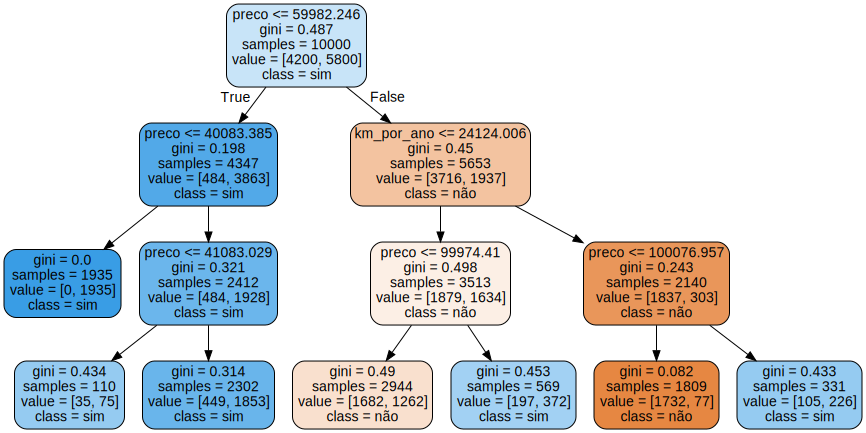

In [52]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, 
                           out_file=None, 
                           filled=True, 
                           rounded=True, 
                           class_names=['não', 'sim'], 
                           feature_names=features
                           )
graph = graphviz.Source(dot_data)
graph